#### A few questions to investigate

- If we change the start time of the input apike train from 0ms to 10ms or 50ms, will it change the behaviour 
of the post-synaptic neuron? 
- what is the suitable run time for our experiment? how can we know if it has convereged?  

In [1]:
from brian2 import *
prefs.codegen.target = "numpy"

In [2]:
def plot_experiment(pre_spike_mon, post_state_mon, S, wmax):
    
    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    w_init = array([wmax * 0.2] * len(S.w))
    plot(S.i, w_init / wmax, '.k')
    xlabel('Synapse index')
    ylabel(r'Weight / $g_max$')
    tight_layout()

    plt.subplot(2,1,2)
    plot(S.i, S.w / wmax, '.k')
    xlabel('Synapse index')
    ylabel(r'Weight / $g_max$')
    tight_layout()
    plt.show()

    # plot(post_state_mon.t/ms, post_state_mon.v[0])
    # xlabel('Time (ms)')
    # ylabel('V (volt)')
    # plt.show()

    plot(pre_spike_mon.t/ms, pre_spike_mon.i, '.k')
    xlabel('Time (ms)')
    ylabel('Neuron index')
    tight_layout()
    plt.show()

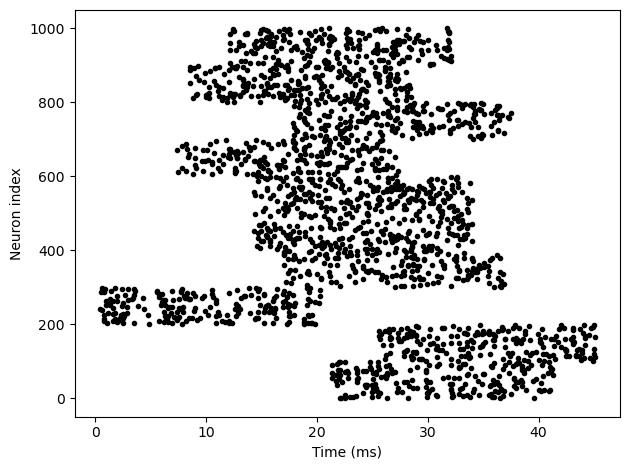

In [3]:
N=1000
groupsize= 100
num_repeat = 40
wmax = 0.55
taupre = taupost = 20*ms
A_pre = 0.005
A_post = - A_pre * 1.05

start_scope()
eqs = '''
starttime : second
rate = int(t> starttime and t<starttime + 20*ms) * 100*Hz : Hz
'''
pre_synapse = NeuronGroup(N, eqs, threshold='rand()<rate*dt')
pre_synapse.starttime = repeat(rand(N//groupsize)*30, groupsize)*ms
pre_spike_mon = SpikeMonitor(pre_synapse)

net = Network(pre_synapse, pre_spike_mon)
net.run(60*ms)


plot(pre_spike_mon.t/ms, pre_spike_mon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
tight_layout()
plt.show()

In [4]:
spikes_i, spikes_t = pre_spike_mon.i, pre_spike_mon.t ## i: index and t: time (ms)

repeat_list = [(i)*50*ms for i in range(num_repeat)]
time_stack= [spikes_t + t for t in repeat_list]
spike_times = np.concatenate(time_stack, axis= 0)* second
spike_idx = np.tile(spikes_i, reps=num_repeat)
input_train = SpikeGeneratorGroup(N, spike_idx, spike_times)

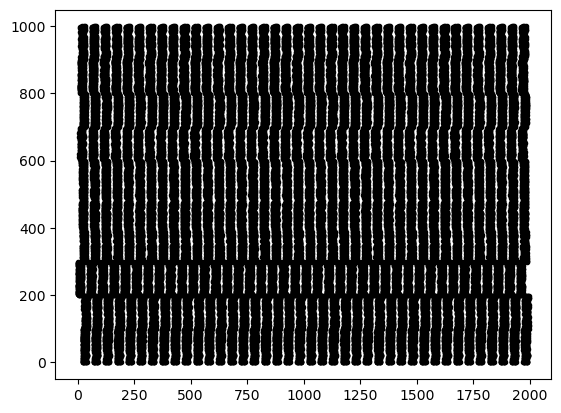

In [5]:
plot(spike_times/ms, spike_idx, '.k')

In [6]:
post_synapse = NeuronGroup(1, model='v:1', threshold= 'v>1', reset='v=0')
S = Synapses(input_train, post_synapse,
            model= '''
                w : 1
                dapre/dt = -apre/ taupre : 1 (clock-driven)
                dapost/dt = -apost/ taupost : 1 (clock-driven)
                ''',
            on_pre='''
                v_post += w
                apre += A_pre
                w = clip(w+apost, 0, wmax)
                ''',
            on_post='''
                apost += A_post
                w = clip(w+apre, 0, wmax)
                ''',
            method='euler'
)

S.connect()
S.w = [0.2*wmax]

pre_spike_mon = SpikeMonitor(input_train)
post_spike_mon = SpikeMonitor(post_synapse)
state_monitor = StateMonitor(S, ['w'], record=True)
post_state_mon = StateMonitor(post_synapse, 'v', record=True)

net = Network(input_train, post_synapse, S, pre_spike_mon, post_spike_mon, state_monitor, post_state_mon)
net.run(50*ms * num_repeat)

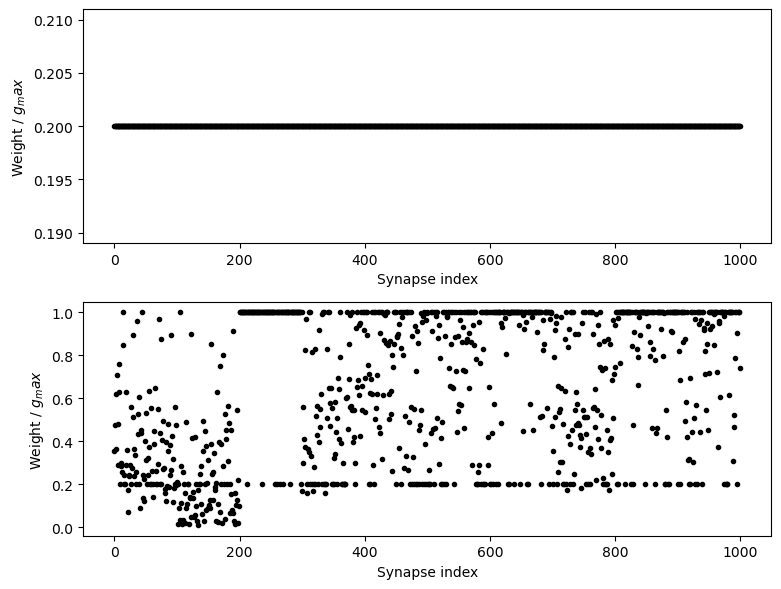

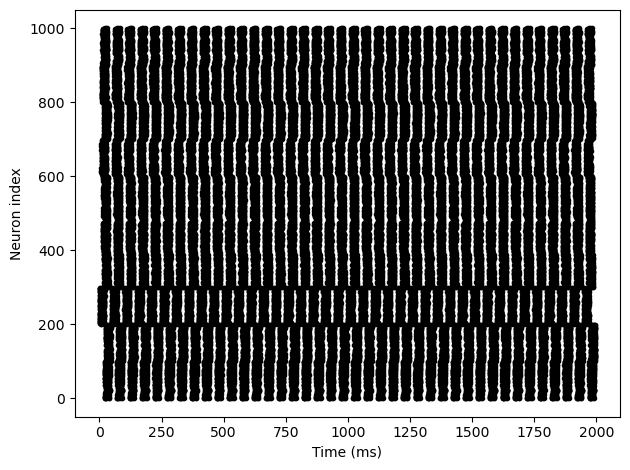

In [7]:
plot_experiment(pre_spike_mon, post_state_mon, S, wmax)

### 0-200, 300-400, 900-1000

SpikeGeneratorGroup(1000, indices=<length 9830 array>, times=<length 9830 array>)

In [ ]:
def run_eperiment(N=1000, groupsize= 100, run_time = 100, wmax = 0.35):
    start_scope()
    eqs = '''
        starttime : second
        rate = int(t> starttime and t<starttime + 20*ms) * 100*Hz : Hz
    '''
    pre_synapse = NeuronGroup(N, eqs, threshold='rand()<rate*dt')
    pre_synapse.starttime = repeat(rand(N//groupsize)*30, groupsize)*ms
    # pre_synapse = NeuronGroup(N, eqs, threshold='rand()< rate*dt')
    # start_times = linspace(0,50, int(N//groupsize))
    # start_times = [0, 90, 200, 250]
    # pre_synapse.starttime = repeat(start_times, N/len(start_times))*ms

    taupre = taupost = 20*ms
    A_pre = 0.005
    A_post = - A_pre * 1.05

    post_synapse = NeuronGroup(1, model='v:1', threshold= 'v>1', reset='v=0')
    S = Synapses(pre_synapse, post_synapse,
                model= '''
                    w : 1
                    dapre/dt = -apre/ taupre : 1 (clock-driven)
                    dapost/dt = -apost/ taupost : 1 (clock-driven)
                    ''',
                on_pre='''
                    v_post += w
                    apre += A_pre
                    w = clip(w+apost, 0, wmax)
                    ''',
                on_post='''
                    apost += A_post
                    w = clip(w+apre, 0, wmax)
                    ''',
                method='euler'
    )

    S.connect()
    S.w = [0.2*wmax]

    pre_spike_mon = SpikeMonitor(pre_synapse)
    post_spike_mon = SpikeMonitor(post_synapse)
    state_monitor = StateMonitor(S, ['w'], record=True)
    post_state_mon = StateMonitor(post_synapse, 'v', record=True)

    run(run_time)
        
    return pre_spike_mon, post_spike_mon, post_state_mon, state_monitor, S

In [ ]:
wmax = 0.35
N=1000
groupsize=100
run_time=155 * ms

pre_spike_mon, post_spike_mon, post_state_mon, state_monitor, S = run_eperiment(N=N, groupsize=groupsize, run_time=run_time, wmax = wmax)

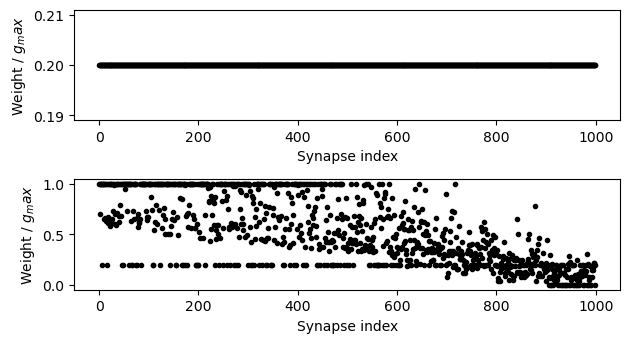

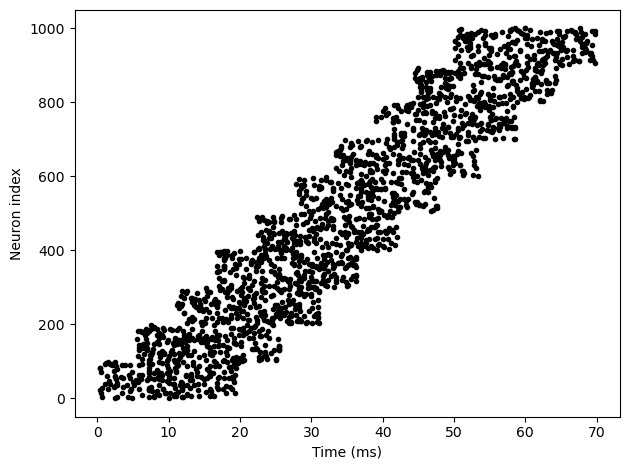

defining `a_pre` as 
```
dapre/dt = (0-apre)/taupre : 1
```

means that the value of `a_pre` deos not depend on time.

In [ ]:
start_scope()
taupre = 20*ms
eqs = '''
    dapre/dt = (0-apre)/taupre : 1
'''
G = NeuronGroup(1, eqs, method='exact')
G.apre = [0] ## by default the initial value of any variable is 0
m = StateMonitor(G, 'apre', record=True)
run(100*ms)
plot(m.t, m.apre[0])